In [2]:
%load_ext autoreload
%autoreload 2
%cd ..

/net/tscratch/people/plghpiotr


In [3]:
%cd cl-adaptation/

/net/tscratch/people/plghpiotr/cl-adaptation


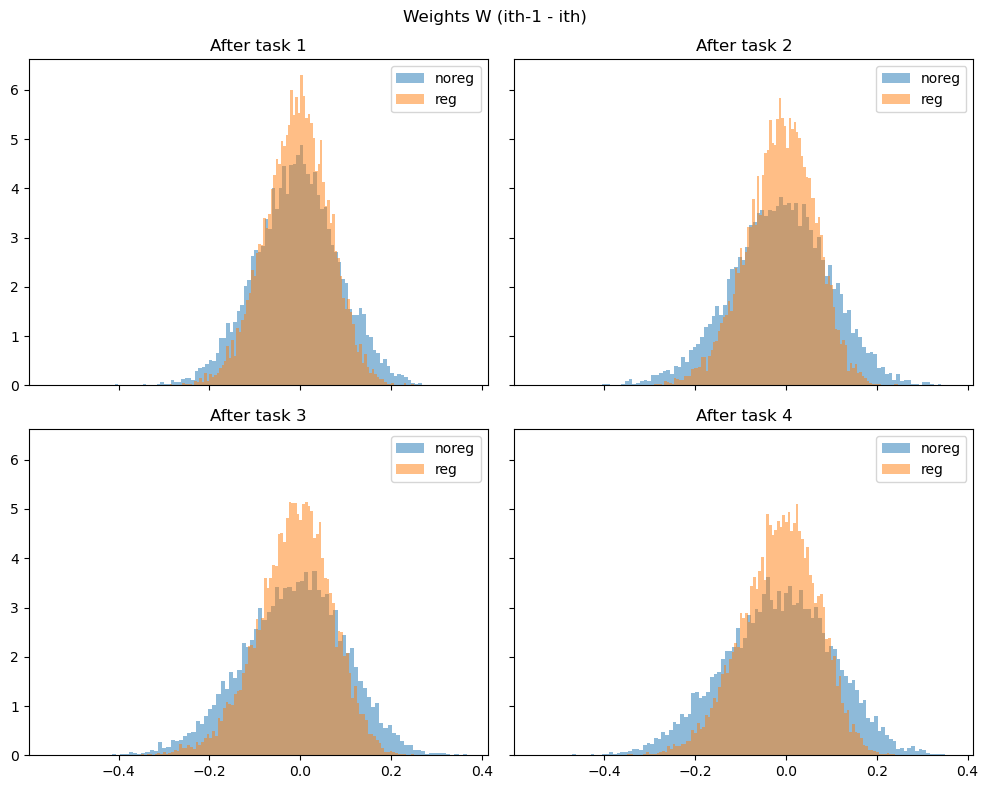

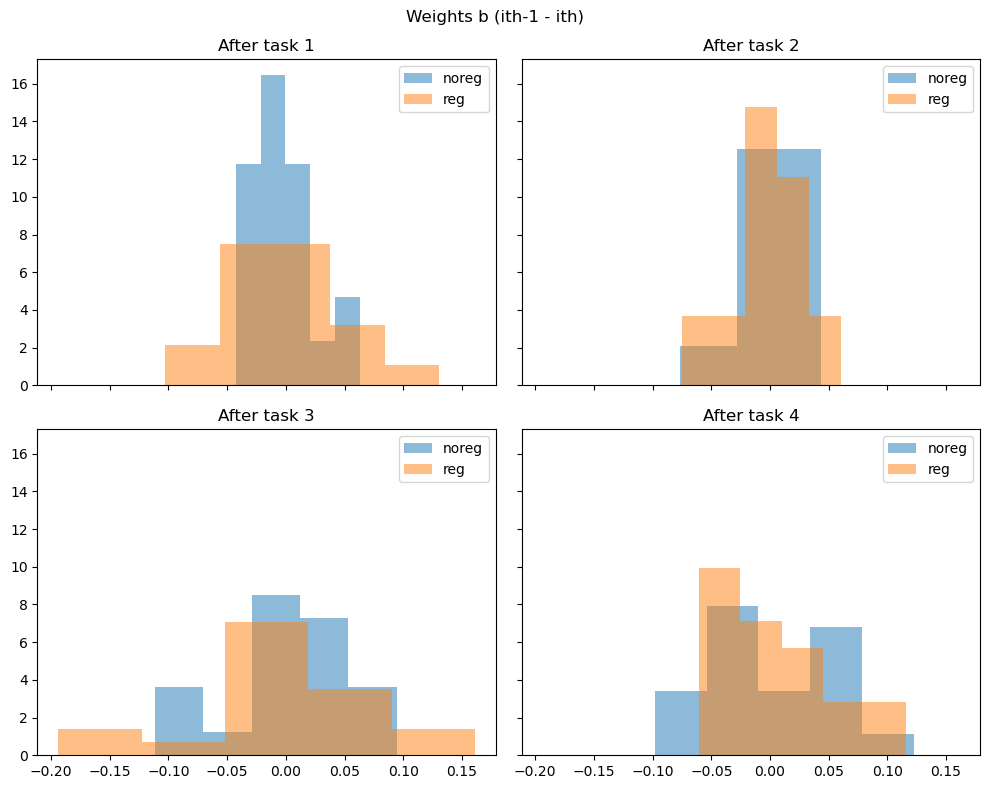

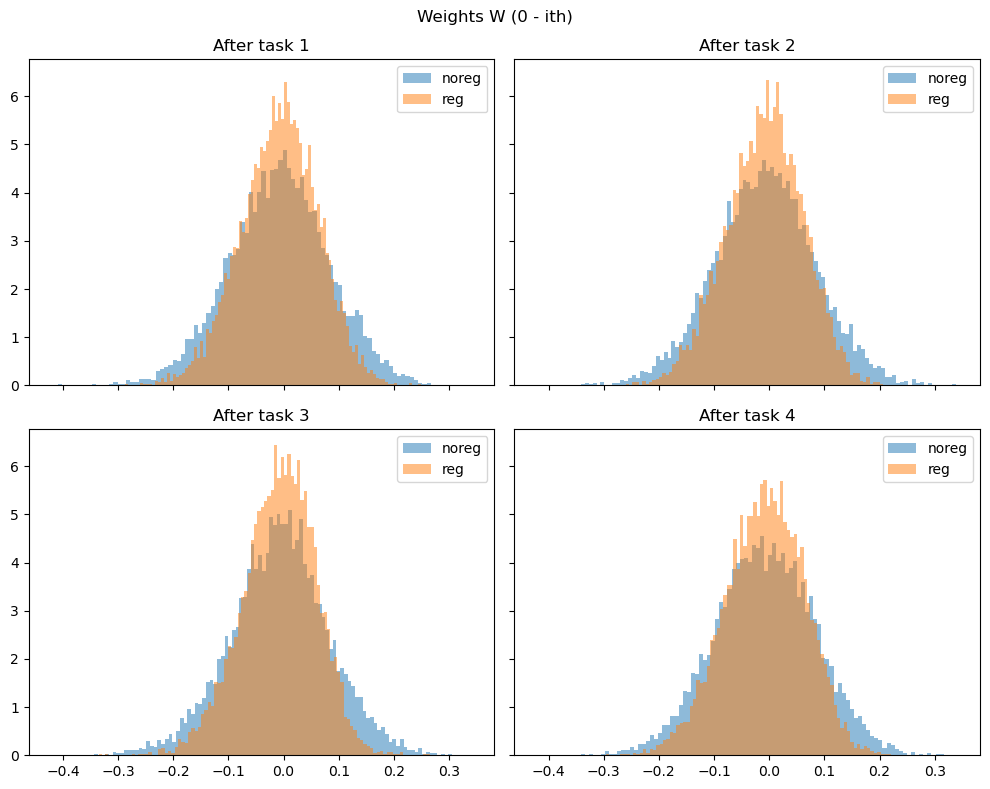

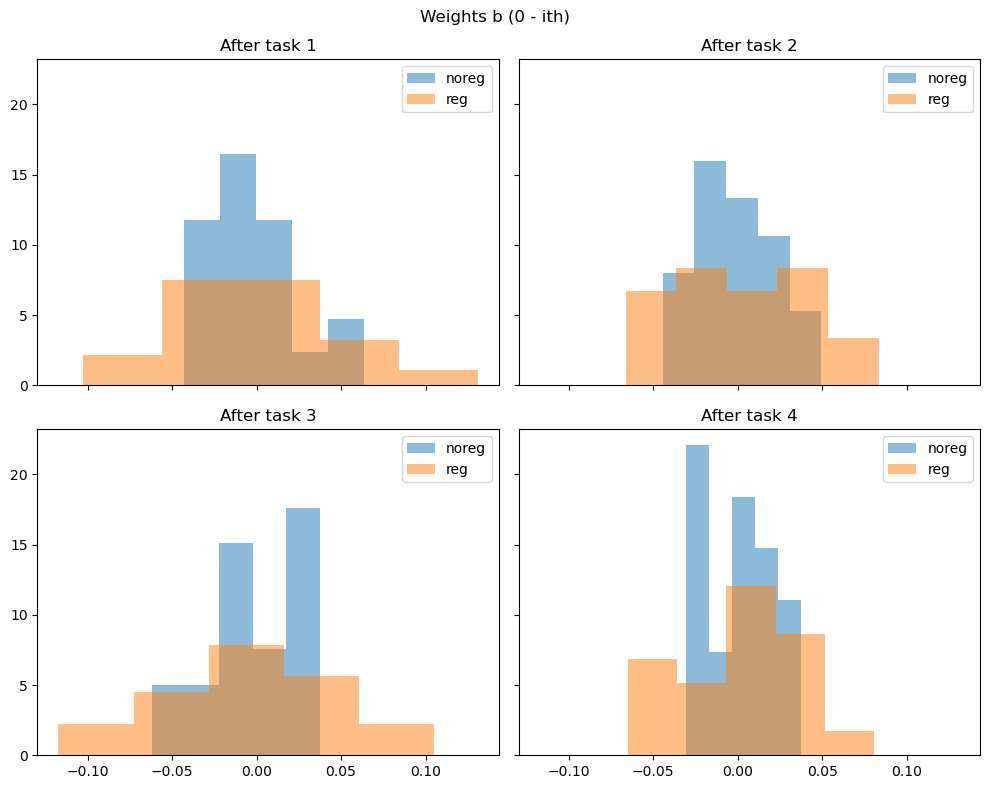

In [4]:
from dataclasses import dataclass, field
from functools import partial
from pathlib import Path
import re
from typing import List
from matplotlib import pyplot as plt
import numpy as np
import torch


def parse_path(filename):
    match = re.match(r"dt_(\d+)_t_(\d+)_", filename)
    if match:
        data_task = int(match.group(1))
        task = int(match.group(2))
    else:
        raise ValueError("Filename format is incorrect")
    return data_task, task


@dataclass
class Weight:
    filename: str
    W: torch.Tensor
    b: torch.Tensor
    varcov: None
    task: int
    data_task: int

    @classmethod
    def from_path(cls, path):
        path = Path(path)

        ckpt = torch.load(path, map_location="cpu")["state_dict"]

        W = ckpt["linear_layer.weight"]
        b = ckpt["linear_layer.bias"]

        data_task, task = parse_path(path.name)
        varcov = None

        return cls(path.name, W, b, varcov, task, data_task)


def get_weigths_and_sort(directory_path: Path) -> List[Weight]:
    paths = list(directory_path.rglob("*.ckpt"))

    weights = [Weight.from_path(path) for path in paths]
    weights = sorted(weights, key=lambda x: x.filename)
    return weights


def get_subsequents(weights):
    nth = list(filter(lambda x: x.data_task - x.task == 1, weights))
    prev_nth = list(filter(lambda x: x.data_task - x.task == 0, weights))
    return nth, prev_nth


def get_zeros(weights):
    all_weights = list(filter(lambda x: x.task == 0, weights))

    prev_nth = [all_weights[0]] * (len(all_weights) - 1)
    nth = all_weights[1:]
    return nth, prev_nth


def get_diffs_W(weights, func):
    nth, prev_nth = func(weights)

    wds = np.asarray(list(map(lambda x: x.W.flatten(), nth)))
    -np.asarray(list(map(lambda x: x.W.flatten(), prev_nth)))
    return wds


def get_diffs_b(weights, func):
    nth, prev_nth = func(weights)

    wds = np.asarray(list(map(lambda x: x.b, nth)))
    -np.asarray(list(map(lambda x: x.b, prev_nth)))
    return wds


def plot(reg, noreg, name, *args, **kwargs):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
    for i in range(4):
        # Determine subplot indices
        row = i // 2
        col = i % 2

        # Plot histogram for the current dataset
        axs[row, col].hist(
            noreg[i], bins=kwargs["bins"], alpha=0.5, label="noreg", density=True
        )
        axs[row, col].hist(
            reg[i], bins=kwargs["bins"], alpha=0.5, label="reg", density=True
        )
        axs[row, col].set_title(f"After task {i+1}")
        axs[row, col].legend()
        plt.grid()

    fig.suptitle(name)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    noreg_path = Path("analysis/02.15/02.15/cifar100_fixed_finetuning_finetuning_noreg")
    noreg_weights = get_weigths_and_sort(noreg_path)

    reg_path = Path(
        "analysis/02.15/02.15/cifar100_fixed_finetuning_finetuning_reg_more"
    )
    reg_weights = get_weigths_and_sort(reg_path)

    for n, r in zip(noreg_weights, reg_weights):
        assert r.task == n.task
        assert r.data_task == n.data_task

    get_diffs_W_subsequent = partial(get_diffs_W, func=get_subsequents)
    get_diffs_b_subsequent = partial(get_diffs_b, func=get_subsequents)

    reg = get_diffs_W_subsequent(reg_weights)
    noreg = get_diffs_W_subsequent(noreg_weights)

    plot(reg, noreg, name="Weights W (ith-1 - ith)", bins=100)

    reg = get_diffs_b_subsequent(reg_weights)
    noreg = get_diffs_b_subsequent(noreg_weights)

    plot(reg, noreg, name="Weights b (ith-1 - ith)", bins=5)

    get_diffs_W_zeros = partial(get_diffs_W, func=get_zeros)
    get_diffs_b_zeros = partial(get_diffs_b, func=get_zeros)

    reg = get_diffs_W_zeros(reg_weights)
    noreg = get_diffs_W_zeros(noreg_weights)

    plot(reg, noreg, name="Weights W (0 - ith)", bins=100)

    reg = get_diffs_b_zeros(reg_weights)
    noreg = get_diffs_b_zeros(noreg_weights)

    plot(reg, noreg, name="Weights b (0 - ith)", bins=5)